### Import Libraries

In [588]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize

### Read the data

In [589]:
train_df_orig = pd.read_csv('train.csv')
train_df_orig.shape

(76020, 371)

In [590]:
test_df_orig = pd.read_csv('test.csv')
test_df_orig.shape

(75818, 370)

In [591]:
train_df_orig.info()
# 371 columns
# Type is int or float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [592]:
# remove ID column as is of no use 
test_id = test_df_orig['ID']
test_df_new = test_df_orig.drop(["ID"],axis=1)
train_df_orig = train_df_orig.drop(['ID'], axis=1)

### Target column analysis

In [593]:
train_df_orig.TARGET.value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

In [594]:
print('percentage of 1 is: ',100*len(train_df_orig[train_df_orig['TARGET']==1]['TARGET'])/len(train_df_orig['TARGET']))
print('percentage of 0 is: ',100*len(train_df_orig[train_df_orig['TARGET']==0]['TARGET'])/len(train_df_orig['TARGET']))

percentage of 1 is:  3.9568534596158904
percentage of 0 is:  96.04314654038411


### Remove Outliers

In [595]:
# Not using this as it ends up removing more than 50% of data
# Q1 = train_df_orig.quantile(0.25)
# Q3 = train_df_orig.quantile(0.75)
# IQR = Q3 - Q1
# print(IQR)
# train_df_temp = train_df_orig[~((train_df_orig < (Q1 - 1.5 * IQR)) |(train_df_orig > (Q3 + 1.5 * IQR))).any(axis=1)]
# print(train_df_temp.shape)

### Feature Extraction

#### Remove Duplicate, Consant Features 

In [596]:
# remove constant columns (std = 0)
remove = []
for col in train_df_orig.columns:
    if train_df_orig[col].std() == 0:
        remove.append(col)
print(len(remove))
train_df_orig.drop(remove, axis=1, inplace=True)
test_df_orig.drop(remove, axis=1, inplace=True)

34


In [597]:
# remove duplicated columns
remove_duplicates = []
cols = train_df_orig.columns
for i in range(len(cols)-1):
    v = train_df_orig[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train_df_orig[cols[j]].values):
            remove_duplicates.append(cols[j])
print(len(remove_duplicates))
train_df_orig.drop(remove_duplicates, axis=1, inplace=True)
test_df_orig.drop(remove_duplicates, axis=1, inplace=True)

29


#### Correlation between features

In [598]:
# compare the correlation between features and remove one of two features that have a correlation higher than 0.9
import numpy as np
corr = abs(train_df_orig.corr())
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = train_df_orig.columns[columns]
selected_columns

Index(['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3', 'imp_op_var40_ult1',
       ...
       'saldo_medio_var13_largo_hace2', 'saldo_medio_var13_largo_hace3',
       'saldo_medio_var29_hace2', 'saldo_medio_var29_hace3',
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3', 'var38',
       'TARGET'],
      dtype='object', length=170)

In [599]:
#Correlation with output variable
cor_target = (corr["TARGET"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.01]
print(len(relevant_features))
relevant_features.index

#No correlation with the target variable found

114


Index(['var15', 'imp_op_var39_comer_ult1', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3', 'imp_op_var41_comer_ult1',
       'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3',
       'imp_op_var41_ult1', 'imp_op_var39_efect_ult1',
       'imp_op_var39_efect_ult3',
       ...
       'saldo_medio_var12_ult3', 'saldo_medio_var13_corto_hace2',
       'saldo_medio_var13_corto_hace3', 'saldo_medio_var13_corto_ult1',
       'saldo_medio_var13_corto_ult3', 'saldo_medio_var13_largo_hace2',
       'saldo_medio_var13_largo_ult1', 'saldo_medio_var13_largo_ult3', 'var38',
       'TARGET'],
      dtype='object', length=114)

In [600]:
# Assigning important correlated features to a new dataframe
# Common important features
final_features= pd.Series(list(set(selected_columns).intersection(set(relevant_features.index))))
train_df_new = train_df_orig[final_features]

In [601]:
# Removing target column for test data
final_features = final_features.drop(final_features[final_features.isin(['TARGET']) == True].index)

In [602]:
train_df_new.shape

(76020, 62)

In [603]:
test_df_new = test_df_orig[final_features]
test_df_new.shape

(75818, 61)

### Scale Data

In [604]:
# # Scale the train data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# Storing data in target and independent variables

y = train_df_new["TARGET"] #target variable
X = train_df_new.drop(["TARGET"],axis=1) #independent variables

# # Fit on training set only.
# scaler.fit(X)
# # Apply transform to both the training set and the test set.
# X = scaler.transform(X)

In [605]:
type(X)

pandas.core.frame.DataFrame

In [606]:
# # Scale the test data
# test_df_new = scaler.transform(test_df_new)

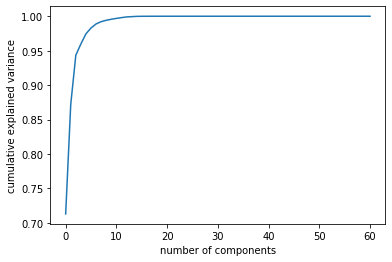

In [607]:
# using PCA to reduce the number of columns
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.cumsum(PCA().fit(X).explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [608]:
# # Make an instance of the PCA Model, keeping 95% of variation
# pca = PCA(.95)
# pca.fit(X_train)
# X_train_new = pca.transform(X_train)
# X_test_new = pca.transform(X_test)

# #Apply PCA on test data
# test_df_new = pca.transform(test_df_new)

# Add PCA components as features
def addPCAfeatures():
    X_normalized = normalize(X, axis=0)
    test_normalized= normalize(test_df_new, axis=0)
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_normalized)
    test_pca=pca.fit_transform(test_normalized)
    print(len(X_pca[:,0]))
    X['PCA1'] = X_pca[:,0]
    X['PCA2'] = X_pca[:,1]
    X['PCA3'] = X_pca[:,2]

    test_df_new['PCA1'] = test_pca[:,0]
    test_df_new['PCA2'] = test_pca[:,1]
    test_df_new['PCA3'] = test_pca[:,2]

    
addPCAfeatures()    

print('Shape of Train data: ', X.shape)
print('Shape of test data: ',test_df_new.shape)

76020
Shape of Train data:  (76020, 64)
Shape of test data:  (75818, 64)


C:\Users\abhishekbhardwaj01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\abhishekbhardwaj01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\abhishekbhardwaj01\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [582]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1,)

In [583]:
X_train.shape, y_train.shape

((60816, 64), (60816,))

### Build the model

In [609]:
# # Create regularization penalty space
# penalty = ['l1', 'l2']

# # Create regularization hyperparameter space
# C = np.logspace(0, 4, 10)

# # Create hyperparameter options
# hyperparameters = dict(C=C, penalty=penalty)

# # Create grid search using 5-fold cross validation
# clf = GridSearchCV(LogisticRegression(solver = 'lbfgs',random_state=1), hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = LogisticRegression().fit(X_train, y_train)

# # View best hyperparameters
# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:', best_model.best_estimator_.get_params()['C'])

# Predict target vector
best_model.score(X_test, y_test)

C:\Users\abhishekbhardwaj01\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abhishekbhardwaj01\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9602736122073139

### Predict and save the results

In [610]:
#Global Function
def predictnsave(ID, filename, model, test_data):
    y_predict  = model.predict_proba(test_data)[:,1]
    #print(np.unique(y_predict,return_counts=True))
    predict_df = pd.DataFrame(columns = ['ID', 'TARGET'])
    predict_df['ID'] = test_ID
    predict_df['TARGET'] = y_predict
    predict_df.to_csv(filename,index=False)

In [611]:
predictnsave(test_ID,'santander_LR_PCA_Probav1.csv',best_model, test_df_new)
#Accuracy of 78 % on private leaderboard

### Improving the results

#### Random Forest Classifier

In [612]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model_randomforestclf = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model_randomforestclf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [613]:
print('Accuracy Score is: ',model_randomforestclf.score(X_test, y_test))
print('ROC_AUC Score: ',roc_auc_score(y_test, model_randomforestclf.predict_proba(X_test)[:, 1]))

Accuracy Score is:  0.9582346750855039
ROC_AUC Score:  0.7963902833616316


In [614]:
predictnsave(test_ID,'santander_RandomForestCLF_PCA_FeatureSelection_Probv1.csv',model_randomforestclf, test_df_new)
#75% on private leaderboard 

#### XGBoost

In [ ]:
!pip install xgboost

In [371]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [383]:
model_xgboost = xgb.XGBClassifier(max_depth=4, n_estimators=110, nthread=-1,seed=12)
# kfold = StratifiedKFold(n_splits=10, random_state=7)
# results = cross_val_score(model_xgboost, X, y, cv=kfold)
# print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [384]:
model_xgboost.fit(X_train_new, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=110, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=12,
              silent=None, subsample=1, verbosity=1)

In [385]:
y_pred = model_xgboost.predict(X_test_new)
y_pred = [round(value) for value in y_pred]

In [386]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.9603393843725335, 0.03966061562746648)

In [387]:
predictnsave(test_ID, 'XGBoost_PCA_Scaled_FeatureSelection_updated.csv',model_xgboost, test_df_new)

(array([0, 1], dtype=int64), array([75813,     5], dtype=int64))


In [380]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [379]:
#Feature selection

clf = ExtraTreesClassifier(random_state=1000)
selector = clf.fit(X_train_new, y_train)


C:\Users\abhishekbhardwaj01\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [381]:
fs = SelectFromModel(selector, prefit=True)

X_train_temp = fs.transform(X_train_new)
X_test_temp = fs.transform(X_test_new)
test_df_temp = fs.transform(test_df_new)

print(X_train_temp.shape, X_test_temp.shape, test_df_temp.shape)

(60816, 9) (15204, 9) (75818, 9)


In [382]:
#--------------------Train Model-------------------------------------------
#xgboost
#@fn_timer 
def trainModel(i):
    m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = i, seed=1000)
    m2_xgb.fit(X_train_temp, y_train, eval_metric="auc", verbose = False,
               eval_set=[(X_test_temp, y_test)])
    return m2_xgb

    
   
# calculate the auc score.   tune the parameters ...
for i in range(8):
    print("max_depth =%s" ,i+1 )
    print("Roc AUC: ", roc_auc_score(y_test, trainModel(i).predict_proba(X_test_temp)[:,1]))

max_depth =%s 1
Roc AUC:  0.5
max_depth =%s 2
Roc AUC:  0.8024433911078355
max_depth =%s 3
Roc AUC:  0.8102098461417544
max_depth =%s 4
Roc AUC:  0.81302514207948
max_depth =%s 5
Roc AUC:  0.8121652882086383
max_depth =%s 6
Roc AUC:  0.8095066752396499
max_depth =%s 7
Roc AUC:  0.8092483385869547
max_depth =%s 8
Roc AUC:  0.809035944856227


In [388]:
probs = trainModel(5).predict_proba(X_test_temp)

In [394]:
trainModel(4).score(X_test_temp,y_test)

0.9603393843725335